In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import tensorflow as tf


In [6]:
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [13]:
# Files' Paths
file_path = '/content/drive/MyDrive/Files and Data/gender and channels csv/binary_labels_5-4FeatureNorm'
features=np.load('/content/drive/MyDrive/Files and Data/gender and channels csv/DE_feature_5-4FeatureNorm.npy') # choose the feature numpy file
rows=features.shape[0]
cols=features.shape[1]
# for  calculation of  number of trails  for traning and testing
percent_train=np.floor(0.75*rows)  # 75 % for testing
percent_test=np.ceil(0.25*rows)   # 25 % for traninig
print(f'row:{rows} cols:{cols} trains:{percent_train} test:{percent_test} ')

row:33280 cols:14 trains:24960.0 test:8320.0 


In [15]:
# Load the CSV file into a DataFrame
labels_gender = pd.read_csv(file_path)
# print(labels_gender.head)
# Assuming 'wavelet_features' is a NumPy array and 'labels' is a DataFrame with two columns 'Class' and 'Gender'
# Split the data into males and females
males = labels_gender[labels_gender['Gender'] == 'Male']
females = labels_gender[labels_gender['Gender'] == 'Female']

# Split males and females into training and test sets and ensure equal no. of training sets between females and males.
#no. of trials=40trial*32subject*26 OSW=33280 total trials==>1040 trail/subject==>12480training males (12 males) and 5200testing males (5 males)
males_train, males_test = train_test_split(males.index, test_size=5200, random_state=42)

#no. of trials=40trial*32subject*26 OSW=33280 total trials==>1040 trail/subject==>12480training males (12 females) and 3120 testing males (3 females)
females_train, females_test = train_test_split(females.index, test_size=3120, random_state=42)

# Combine the training sets for both genders
train_indices = np.concatenate([males_train, females_train])

# Create the test set
test_indices = np.concatenate([males_test, females_test])

# Use the indices to select the corresponding data from the 'wavelet_features' NumPy array
train_data = features[train_indices, :]
test_data = features[test_indices, :]

# Extract the train and test labels from the DataFrame
train_labels = labels_gender.loc[train_indices]
test_labels = labels_gender.loc[test_indices]


FileNotFoundError: ignored

In [ ]:
X_train=np.array(train_data)
# To drop a single column 'ColumnName'
train_labels = train_labels.drop('Gender', axis=1)
# we have labels for both arousal and val in train_labels
y_train=np.array(train_labels)
y_train_val=y_train[:,0]  # get val labes
y_train_arl=y_train[:,1]  # get arousal label

print(y_train_val.shape,y_train_arl.shape)
X_test=np.array(test_data)
test_labels=test_labels.drop('Gender',axis=1)
print(test_labels.head)
y_test=np.array(test_labels)
y_test_val=y_test[:,0]  # val test set
y_test_arl=y_test[:,1]  # arousal test set

# Assuming you have a DataFrame called 'labels_df' with the labels in a column named 'class_label'
class_counts_val = labels_gender['Binary Label val'].value_counts()
class_counts_arl= labels_gender['Binary Label arl'].value_counts()
print(class_counts_val)
print(class_counts_arl)
print(X_test.shape)

(24960,) (24960,)
<bound method NDFrame.head of        Binary Label val  Binary Label arl
16345                 0                 0
31125                 1                 1
12378                 0                 1
733                   0                 0
5445                  1                 1
...                 ...               ...
31820                 1                 0
1135                  1                 0
7416                  1                 1
31648                 1                 0
3651                  0                 0

[8320 rows x 2 columns]>
1    21008
0    12272
Name: Binary Label val, dtype: int64
1    21216
0    12064
Name: Binary Label arl, dtype: int64
(8320, 14)


In [ ]:
print(X_train.shape,X_test.shape)
print(y_test_val.shape,y_test_arl.shape)
#%%
# Find unique classes
unique_classes = np.unique(y_train)
print(unique_classes)
## apply z score scaling to both train and test set
scaler= StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)

# apply smote  transform only on training data
oversample = SMOTE()
over_X, over_y = oversample.fit_resample(X_train,y_train_val)
print(over_X.shape,over_y.shape,X_train.shape,y_train_val.shape)
unique_values, counts = np.unique(over_y, return_counts=True)
frequency_dict = dict(zip(unique_values, counts))

print("Frequency of each value:")
print(frequency_dict)

(24960, 14) (8320, 14)
(8320,) (8320,)
[0 1]
(31310, 14) (31310,) (24960, 14) (24960,)
Frequency of each value:
{0: 15655, 1: 15655}


In [ ]:
#KNN
trainscores=[]
testscores=[]
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(over_X, over_y)
train_score=knn.score(over_X, over_y)
test_score=knn.score(X_test,y_test_val)
print("Train Scores：", train_score)
print("Test Scores：", test_score)
trainscores.append(train_score)
testscores.append(test_score)

Train Scores： 0.7309485787288407
Test Scores： 0.5040865384615385


In [ ]:
#SVM
from sklearn.svm import SVC
svc = SVC(kernel='rbf',C = 0.1)
svc.fit(over_X, over_y)
train_score=svc.score(over_X, over_y)
test_score=svc.score(X_test,y_test_val)
print("Train Scores：", train_score)
print("Test Scores：", test_score)
trainscores.append(train_score)
testscores.append(test_score)

Train Scores： 0.584669434685404
Test Scores： 0.5358173076923077


In [ ]:
#Decision Tree
from sklearn import tree
dtree = tree.DecisionTreeClassifier(max_depth=20,min_samples_split=4)
dtree = dtree.fit(over_X, over_y)
train_score=dtree.score(over_X, over_y)
test_score=dtree.score(X_test,y_test_val)
print("Train Scores：", train_score)
print("Test Scores：", test_score)
trainscores.append(train_score)
testscores.append(test_score)

Train Scores： 0.7959437879271798
Test Scores： 0.503125


In [ ]:
#RandomForest
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(n_estimators=50,max_depth=20,min_samples_split=5)
rf=rf.fit(over_X, over_y)
train_score=rf.score(over_X, over_y)
test_score=rf.score(X_test,y_test_arl)
print("Train Scores：", train_score)
print("Test Scores：", test_score)
trainscores.append(train_score)
testscores.append(test_score)

Train Scores： 0.9765570105397636
Test Scores： 0.534375


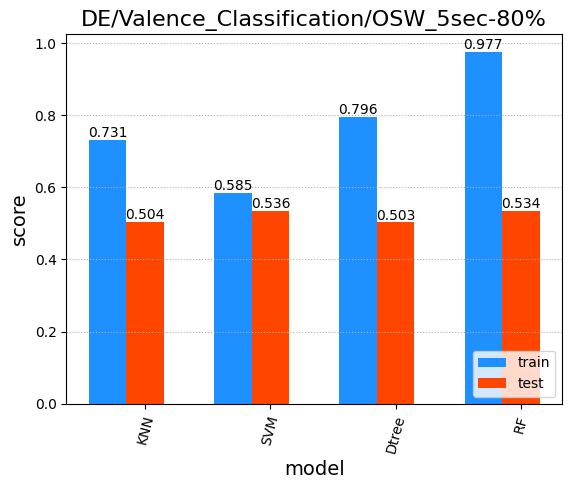

In [ ]:
model_name = ["KNN","SVM","Dtree","RF"]
import matplotlib.pyplot as plt
plt.title('DE/Valence_Classification/OSW_5sec-80%', fontsize=16)
plt.xlabel('model', fontsize=14)
plt.ylabel('score', fontsize=14)
plt.grid(linestyle=':', axis='y')
x = np.arange(4)
a = plt.bar(x - 0.3, trainscores, 0.3, color='dodgerblue', label='train', align='center')
b = plt.bar(x, testscores, 0.3, color='orangered', label='test', align='center')
for i in a + b:
    h = i.get_height()
    plt.text(i.get_x() + i.get_width() / 2, h, '%.3f' % h, ha='center', va='bottom')
plt.xticks(x,model_name,rotation=75)
plt.legend(loc='lower right')
plt.show()